** Final project code **

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pygsp as pg
import matplotlib.pylab as plt

In [3]:
from load_and_preprocessing import load_data_and_filter_members, assign_party_to_names, save_adjacencies_per_year, get_adjacencies_per_year
from helpers import label_to_numeric, get_lap_eigendecomp, visualize_community_isolation, visualize_node_loyalty, visualize_modularity, visualize_party_orientation, make_signal
from network_analysis import compute_community_loyalty, detect_partitions, compute_modularity, centralities
from conseil_national_evolution import create_evolution_features_v1

Create adjacencies per year and per legislature and save them in folder (needs to be created beforehand):

In [4]:
legislatures = ['48','49', '50']
year_of_leg = [4,4,3]
save_adjacencies_per_year(legislatures, year_of_leg, save=True)
save_adjacencies_per_year(legislatures, None, save=True)

(Nbr. of councillors, nbr. of votes) before filter: (202, 146)
(Nbr. of councillors, nbr. of votes) after filter: (196, 145)
(Nbr. of councillors, nbr. of votes) before filter: (202, 604)
(Nbr. of councillors, nbr. of votes) after filter: (196, 603)
(Nbr. of councillors, nbr. of votes) before filter: (207, 411)
(Nbr. of councillors, nbr. of votes) after filter: (191, 410)
(Nbr. of councillors, nbr. of votes) before filter: (203, 528)
(Nbr. of councillors, nbr. of votes) after filter: (195, 528)
(Nbr. of councillors, nbr. of votes) before filter: (204, 419)
(Nbr. of councillors, nbr. of votes) after filter: (194, 418)
(Nbr. of councillors, nbr. of votes) before filter: (206, 473)
(Nbr. of councillors, nbr. of votes) after filter: (192, 473)
(Nbr. of councillors, nbr. of votes) before filter: (209, 358)
(Nbr. of councillors, nbr. of votes) after filter: (188, 358)
(Nbr. of councillors, nbr. of votes) before filter: (201, 306)
(Nbr. of councillors, nbr. of votes) after filter: (197, 306)


In [5]:
# Get adjacency of 50th legislature to draw laplacian eigenmap
adjacencies, node_indices = get_adjacencies_per_year(['50'],None)

Assigning parties to the councillors from the dataset loaded above:

In [6]:
name_with_party = assign_party_to_names('../data/Ratsmitglieder_1848_FR.csv', node_indices[0])
name_with_party.head()

,Counc_Id,CouncillorName,PartyAbbreviation
0,3907,Thorens Goumaz Adèle,PES
1,3923,Marra Ada,PSS
2,3897,Moser Tiana Angelina,pvl
3,3902,Rickli Natalie,UDC
4,3875,Eichenberger-Walther Corina,PLR


Translating the party label into a numerical value:

In [7]:
# Example here is with parties, but the same function works for any kind of dictionary, eg. lobbying mandates
party_map = {'UDC': 6,'PSS': -6,'PDC':0,'BastA':-3,'PLR':5,'pvl':-2,
             'PES':-5, 'PBD':2, 'PdT':-4,'PLS':5,
             'PRD':5, 'MCR':4, 'PEV':-1, 'Lega':3, 'csp-ow':1, 'Al':-7,'FraP!':-8, 'GB':7, 'CSPO':8 }

name_with_party_num, labels_in_data = label_to_numeric(name_with_party, 'PartyAbbreviation', party_map, ret_values=True)

Find partitions based on Louvain method and calculate modularity

In [8]:
partitions, modularity = detect_partitions(adjacencies[0], resolution=1)

Draw some eigenmaps and plot party membership as signal:

In [9]:
adjacency = adjacencies[0]
eigenvals, eigenvectors = get_lap_eigendecomp(adjacency, lap_type='normalized', ret_eigval=True)

In [10]:
partition_signal = make_signal(adjacency.shape[0],partitions)
party_signal = name_with_party_num['PartyAbbreviation'].values

name_labels = name_with_party['CouncillorName'].values
colorbar_labels = ['UDC', 'PLR', 'MCR', 'LEGA', 'PBD', 'csp-ow', 'PDC', 'PEV', 'pvl', 'BastA', 'PdT', 'PES', 'PSS']

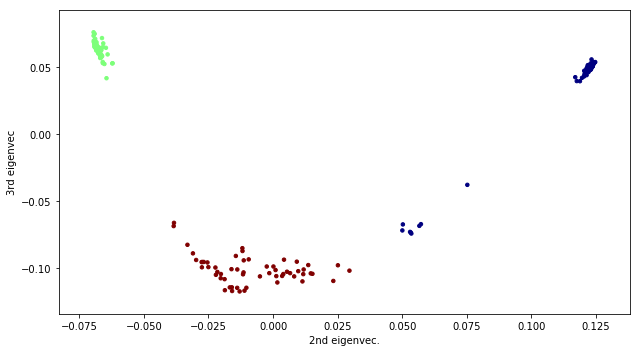

In [11]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.scatter(eigenvectors[:,1], eigenvectors[:,2], c=partition_signal, s=12, vmin=0, vmax=2, cmap="jet")
ax.set_xlabel("2nd eigenvec.")
ax.set_ylabel("3rd eigenvec")
# Uncomment for name labels
#for i, txt in enumerate(name_labels):
#    ax.annotate(txt, (eigenvectors[i,1], eigenvectors[i,2]), xytext=(1,1), textcoords='offset points')
    
#ax.set_title('Position on political spectrum by party ')
fig.tight_layout()
fig.savefig('figures/eigenmap_modpartition.png', dpi=800, bbox_inches = "tight")

Set colorbar to whatever

**Party orientation assessment**

In [12]:
legislatures=['48','49','50']
years_of_leg = [4,4,3]
# Compute average orientation of a party per year
party_evolution_df, years = create_evolution_features_v1(legislatures, years_of_leg)

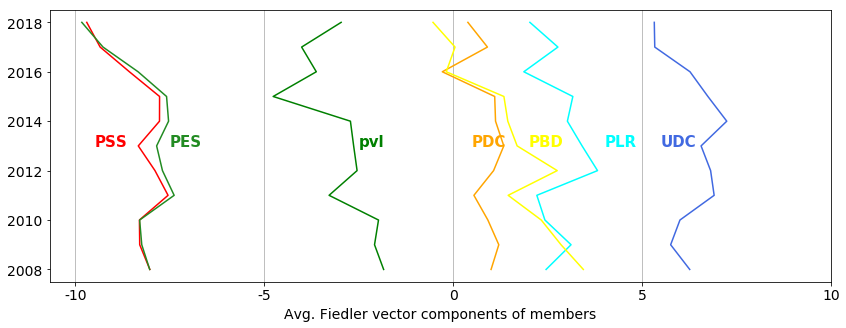

In [13]:
party_to_be_plotted = ['UDC','PSS','PDC','pvl','PLR','PES','PBD']
party_colors = ['royalblue','r', 'orange', 'g', 'cyan', 'forestgreen', 'yellow']
party_color_map = dict((key, value) for (key, value) in zip(party_to_be_plotted, party_colors))

visualize_party_orientation(party_evolution_df, years, party_color_map)


** Modularity analysis **

In [14]:
legislatures=['48','49','50']
years_of_leg = [4,4,3]
modularity_data, years = compute_modularity(legislatures, years_of_leg, resolution=1)


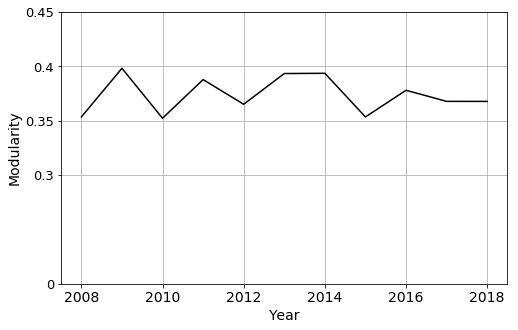

In [15]:
visualize_modularity(modularity_data, years)

** Community "loyalty" analysis**

In [16]:
leg = ['48','49','50']
leg_years = None
# Analyze for communities formed by modularity maximization
community_type = 'party'


communities, community_size, community_loyalty, node_loyalty, years = compute_community_loyalty(community_type, leg, leg_years)

C:\Users\silus\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


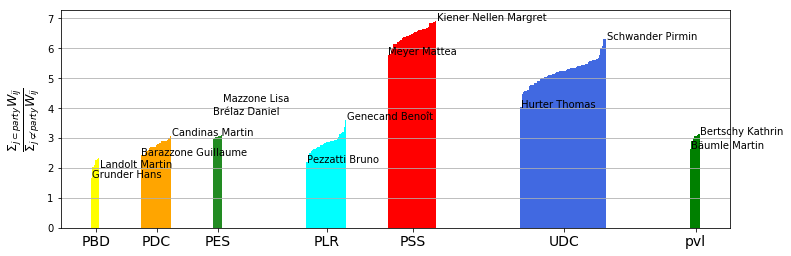

In [17]:
node_index = pd.read_csv('node_indices/node_index_50_all.csv', sep =',')
visualize_node_loyalty(node_loyalty[2], party_color_map, padding=30, node_list=node_index)

**Party isolation analysis**

C:\Users\silus\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


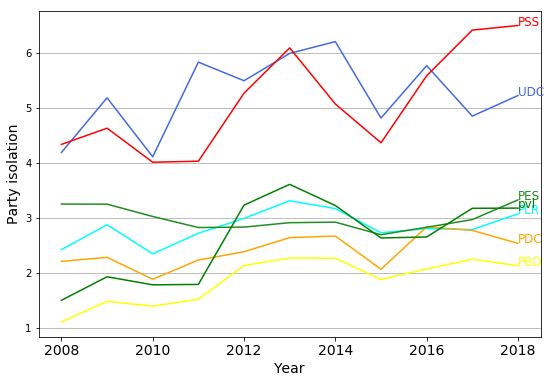

In [18]:
leg_years = [4,4,3]
communities, community_size, community_loyalty, node_loyalty, years = compute_community_loyalty(community_type, leg, leg_years)
visualize_community_isolation(communities, community_size, community_loyalty, years, party_color_map)

**Centrality**

In [ ]:
legislatures=['48','49','50']
years_of_leg = [4,4,3]
centrality, years = centralities(legislatures, years_of_leg, 0.5)